# Melodia Records - Análise exploratória
Este notebook tem como objetivo apresentar a análise exploratória realizada sobre a base de dados fornecida pela empresa. Ao longo do documento, são descritas e executadas as principais etapas de compreensão, tratamento e visualização dos dados.
## 1- Importando as 3 bases e bibiotecas 

In [1]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from ast import literal_eval
db_tracks = pd.read_csv('spotify_tracks.csv')
artistas_df = pd.read_csv('spotify_artists.csv')
db_albuns = pd.read_csv('spotify_albums.csv')

### 1.1- Pré-processamento de db_tracks

In [2]:
#Verificando dados faltantes
db_tracks.isnull().sum()

Unnamed: 0           0
album_id             0
analysis_url         0
artists_id           0
available_markets    0
href                 0
name                 0
playlist             0
popularity           0
preview_url          0
dtype: int64

In [3]:
#Retirando colunas que não são necessárias para a análise
db_tracks_backup = db_tracks
db_tracks.drop(['Unnamed: 0','analysis_url', 'href', 'preview_url'], axis=1, inplace=True)

### 1.2- Pré-processamento de artist_df

In [4]:
#Verificando dados faltantes
artistas_df.isnull().sum()

Unnamed: 0           0
artist_popularity    0
followers            0
genres               0
id                   0
name                 1
track_id             0
track_name_prev      0
type                 0
dtype: int64

In [5]:
# Remover linhas com valores ausentes
artistas_df = artistas_df.dropna()  

In [6]:
#Retirando colunas que não são necessárias para a análise
artistas_df = artistas_df.drop('Unnamed: 0', axis=1)  
artistas_df = artistas_df.drop('type', axis=1)

In [7]:
(artistas_df['genres'] == '[]').sum() # Verifica se há gêneros vazios

np.int64(23539)

Nota-se a presença de uma quantidade elevada de gêneros vazios. Essa coluna será completada futuramente após o merge das 3 bases de dados

### 1.3- Pré-processamento de db_albuns

In [8]:
#Verificando dados faltantes
db_albuns.isnull().sum() 

Unnamed: 0                0
album_type                0
artist_id                 0
available_markets         0
external_urls             0
href                      0
id                        0
images                    0
name                      0
release_date              0
release_date_precision    0
total_tracks              0
track_id                  0
track_name_prev           0
uri                       0
type                      0
dtype: int64

In [9]:
#Retirando colunas que não são necessárias para a análise
db_albuns.drop(['Unnamed: 0','href', 'external_urls', 'images', 'uri'], axis=1, inplace=True)

## 2- Merge das 3 bases de dados

In [10]:
cols_drop_albuns = ['Unnamed: 0', 'external_urls', 'href', 'uri', 'type', 'available_markets', 'images', 'track_name_prev']
cols_drop_artists = ['Unnamed: 0', 'type', 'track_id', 'track_name_prev']
cols_drop_tracks = ['Unnamed: 0', 'analysis_url', 'href', 'available_markets', 'preview_url']

db_albuns = db_albuns.drop(columns=cols_drop_albuns, errors='ignore')
db_artists = artistas_df.drop(columns=cols_drop_artists, errors='ignore')
db_tracks = db_tracks.drop(columns=cols_drop_tracks, errors='ignore')

merge1 = pd.merge(db_albuns, db_artists, left_on='artist_id', right_on='id', how='inner')

db_final = pd.merge(merge1, db_tracks, left_on='id_x', right_on='album_id', how='inner')

db_final.drop(columns=['id_x', 'name_x', 'id_y', 'artists_id'], inplace=True)

db_final.head()


,album_type,artist_id,release_date,release_date_precision,total_tracks,track_id,artist_popularity,followers,genres,name_y,album_id,name,playlist,popularity
0,single,3DiDSECUqqY1AuBP8qtaIa,2019-02-08,day,6,2iejTMy9XZ8Gaae0aQ2yl0,79,5946074,"['hip pop', 'neo soul', 'pop', 'r&b', 'urban c...",Alicia Keys,1gAM7M4rBwEbSPeAQR2nx1,If I Ain't Got You - Radio Edit,Chillout Session,41.0
1,album,6s1pCNXcbdtQJlsnM1hRIA,2019-03-01,day,8,1WQfghEjszJJ4H8MAWrQ2C,57,135831,"['classical', 'compositional ambient', 'russia...",Dmitri Shostakovich,4KfJZV7WfolYlxBzOTo66s,"Symphony No. 5 in D Minor, Op. 48: II Allegretto",Classical New Releases: Spotify Picks,37.0
2,single,5YjfNaHq05WrwldRe1QSBc,2019-03-14,day,1,3jJKj4QTK3v18ZSwpk7AcV,18,118,[],Brandon Mints,7nLYY7uAVUb57kpd7tZxnS,Take My Bass,Bangers,4.0
3,single,2G9Vc16JCpnZmK4uGH46Fa,2016-11-16,day,1,1xGtDafUZbHyYC3Xarcbrj,24,309,[],DØ CHEF DØ,6p20Rt4x2Qn5mUMRi1s6pj,Hypnotizing (Are U),Smukfest 2019,27.0
4,single,2dwM9OcE4c3Ph1UBINSodx,2018-07-20,day,1,0gWtsXvXOzAT6FtM3ur8in,24,1394,[],Alejo García,1XeoOqC1q7U2iyLEQJ64cu,Sunshine,Nuevo Macondo,30.0


### 2.1- Completar gêneros faltantes

Durante a análise, foi identificada a presença de valores ausentes na coluna de gêneros. Para preservar a consistência da base de dados, foi aplicada uma estratégia para imputação desses valores.

A abordagem adotada consistiu em, para cada linha com registros de gêneros nulos, buscar outras entradas correspondentes ao mesmo artista / album / data de lançamento que já continham informações válidas de gênero. Essas informações existentes foram então replicadas de forma coerente para as linhas em que o gênero se encontrava ausente.

In [11]:
db_final['genres'] = db_final['genres'].apply(lambda x: np.nan if x == '[]' else x)

db_final['genres'] = db_final.groupby('album_id')['genres'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))

db_final['genres'] = db_final.groupby('name_y')['genres'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))

db_final['genres'] = db_final.groupby('name')['genres'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))

db_final['genres'] = db_final.groupby('artist_id')['genres'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))

db_final['genres'] = db_final.groupby('release_date')['genres'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))


/var/folders/_l/4nhps33j6z54025qpbx1zqh40000gn/T/ipykernel_28337/606587256.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  db_final['genres'] = db_final.groupby('album_id')['genres'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))
/var/folders/_l/4nhps33j6z54025qpbx1zqh40000gn/T/ipykernel_28337/606587256.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  db_final['genres'] = db_final.groupby('album_id')['genres'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))
/var/folders/_l/4nhps33j6z54025qpbx1zqh40000gn/T/ipykernel_28337/606587256.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use o

In [12]:
print(db_final['genres'].isna().sum())

288


## 3- Gráficos e insights


### 3.1 - Quantidade de albuns por década e por ano

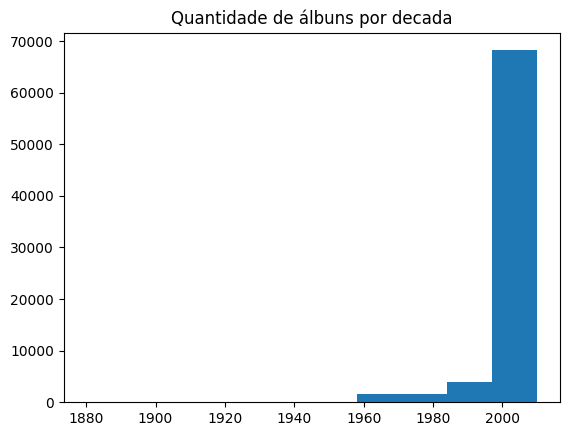

In [13]:
db_albuns['release_date'] = pd.to_datetime(db_albuns['release_date'],format='mixed' ,errors='coerce').dt.year
db_albuns['decada'] = (db_albuns['release_date']//10) * 10

plt.hist(db_albuns['decada'])
plt.title('Quantidade de álbuns por decada')
plt.show()

### 3.2 - Quantidade de album, single e compilation

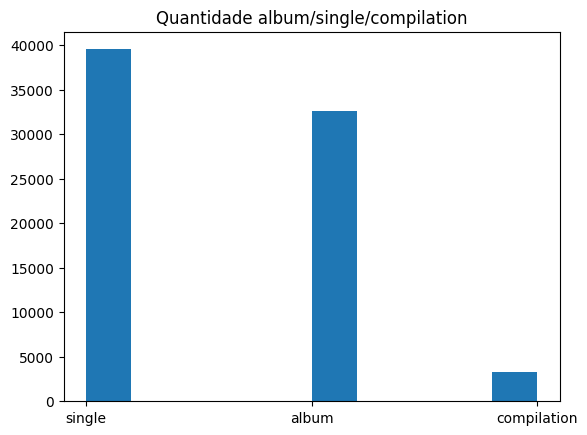

In [14]:
plt.hist(db_albuns['album_type'])
plt.title('Quantidade album/single/compilation')
plt.show()

### 3.3 - Distribuição da popularidade de artista

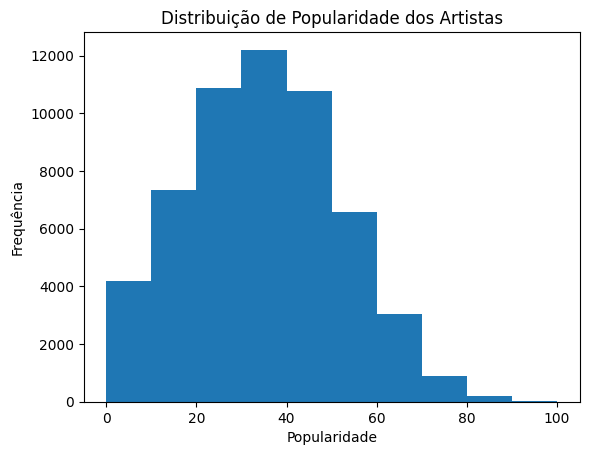

In [15]:
plt.hist(artistas_df['artist_popularity'])
plt.title('Distribuição de Popularidade dos Artistas')
plt.xlabel('Popularidade') 
plt.ylabel('Frequência')
plt.show()

### 3.4 - Distribuição da popularidade de música

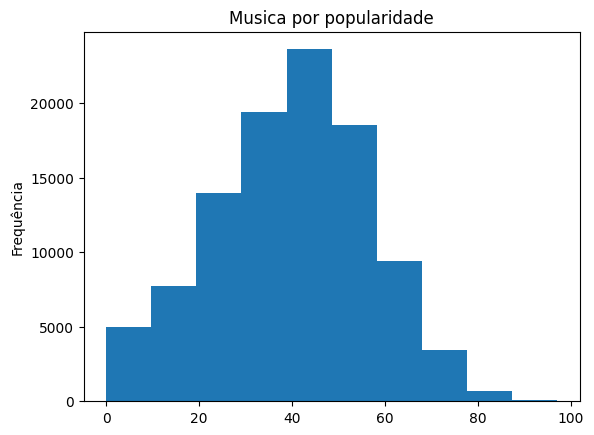

In [16]:
plt.hist(db_tracks['popularity'])
plt.title('Musica por popularidade')
plt.ylabel('Frequência')
plt.show()

### 3.5 - Popularidade por tipo de lançamento

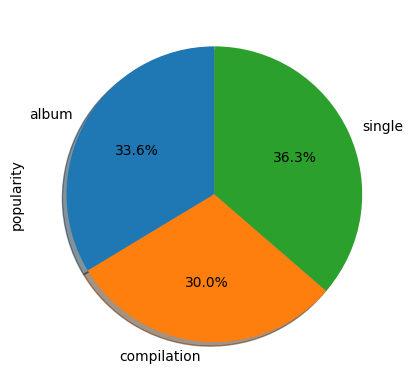

In [17]:
popularidade_por_album_type = db_final.groupby('album_type')['popularity'].mean().dropna()
popularidade_por_album_type.plot(kind='pie', autopct='%1.1f%%', startangle=90, shadow=True) 

plt.show()

### 3.6 - Popularidade de artista por seguidores

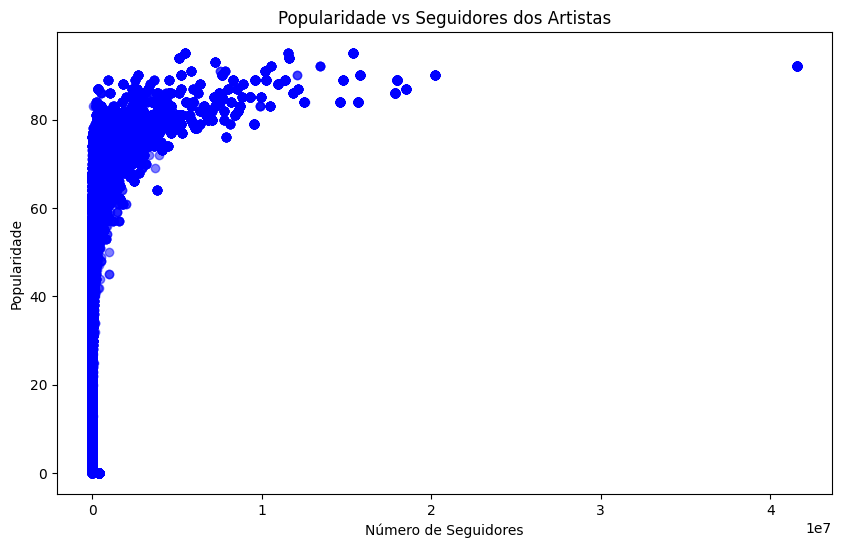

In [18]:

plt.figure(figsize=(10, 6))
plt.scatter(db_final['followers'], db_final['artist_popularity'], color='blue', alpha=0.5)


plt.title('Popularidade vs Seguidores dos Artistas')
plt.xlabel('Número de Seguidores')
plt.ylabel('Popularidade')

plt.show()


### 3.7 - Popularidade por gênero

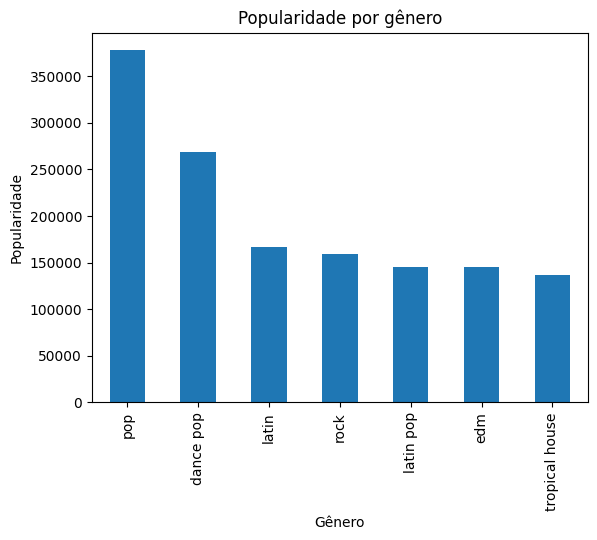

In [19]:
db_final['genres'] = db_final['genres'].apply(lambda x: literal_eval(x) if isinstance(x, str) else x)

genero_pesado = {}

for _, row in db_final.iterrows():
    generos = row['genres']
    peso = row['popularity']
    
    # Pula se a coluna genres não for lista ou se a popularidade for nula
    if not isinstance(generos, list) or pd.isna(peso):
        continue
    
    for genero in generos:
        genero_pesado[genero] = genero_pesado.get(genero, 0) + peso

genero_series = pd.Series(genero_pesado).sort_values(ascending=False)

top_10_generos = genero_series.head(7)
top_10_generos.plot(kind='bar')
plt.ylabel('Popularidade')
plt.xlabel('Gênero')
plt.title('Popularidade por gênero')
plt.show()

### 3.8 - Popularidade por tempo

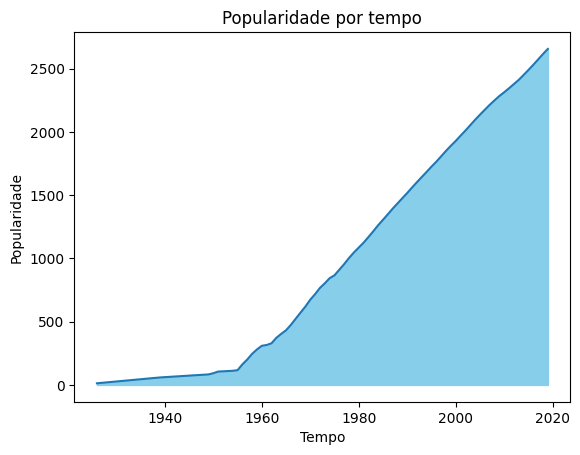

In [20]:
db_final['release_date'] = pd.to_datetime(db_final['release_date'], errors='coerce')
db_final['release_year'] = db_final['release_date'].dt.year


popularidade_por_ano = db_final.groupby('release_year')['popularity'].mean().dropna()

pop_acumulada = popularidade_por_ano.cumsum()

pop_acumulada.plot(kind='line')
plt.fill_between(pop_acumulada.index, pop_acumulada.values, color='skyblue')
plt.ylabel('Popularidade')
plt.xlabel('Tempo')
plt.title('Popularidade por tempo')
plt.show()

### 3.9 - Quantidade de faixas por popularidade

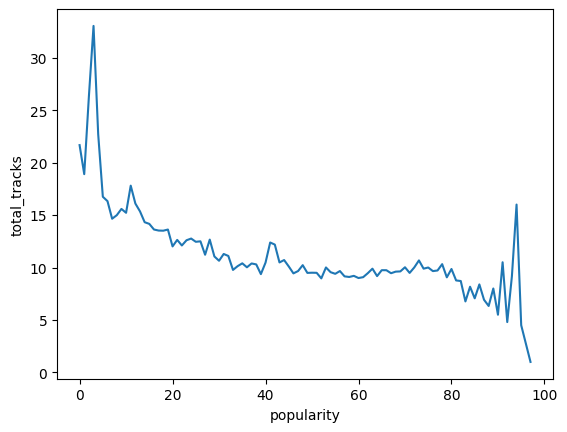

In [21]:
popularidade_por_qtd = db_final.groupby('popularity')['total_tracks'].mean().dropna()

popularidade_por_qtd.plot(kind='line')
plt.ylabel('total_tracks')
plt.show()

In [22]:
pop_artistas = db_final[db_final['genres'].apply(lambda x: isinstance(x, list) and 'pop' in [g.lower() for g in x])]
dance_pop_artistas = db_final[db_final['genres'].apply(lambda x: isinstance(x, list) and 'dance pop' in [g.lower() for g in x])]
latin_artistas = db_final[db_final['genres'].apply(lambda x: isinstance(x, list) and 'latin' in [g.lower() for g in x])]

pop_ranking = pop_artistas.groupby('name_y')['artist_popularity'].mean().sort_values(ascending=True)
dancepop_ranking = dance_pop_artistas.groupby('name_y')['artist_popularity'].mean().sort_values(ascending=True)
latin_ranking = latin_artistas.groupby('name_y')['artist_popularity'].mean().sort_values(ascending=True)


### 3.10 - Top 10 Artistas de Pop

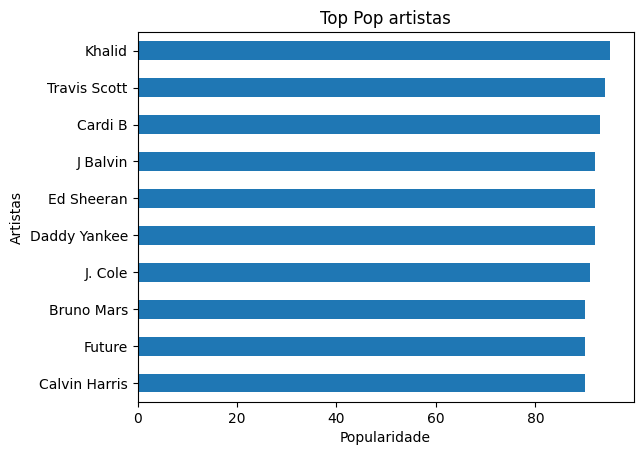

In [23]:
pop_ranking.tail(10).plot(kind='barh')
plt.title('Top Pop artistas')
plt.ylabel('Artistas')
plt.xlabel('Popularidade')
plt.show()

### 3.11 - Top 10 Artistas de Dance Pop

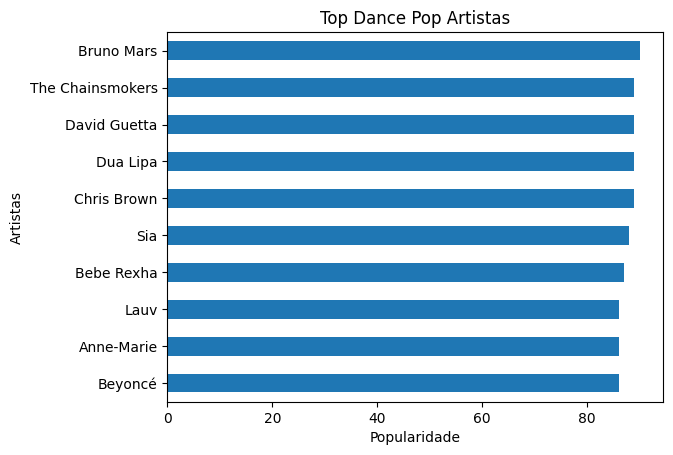

In [24]:
dancepop_ranking.tail(10).plot(kind='barh')
plt.title('Top Dance Pop Artistas')
plt.ylabel('Artistas')
plt.xlabel('Popularidade')
plt.show()

### 3.12 - Top 10 Artistas de Latino

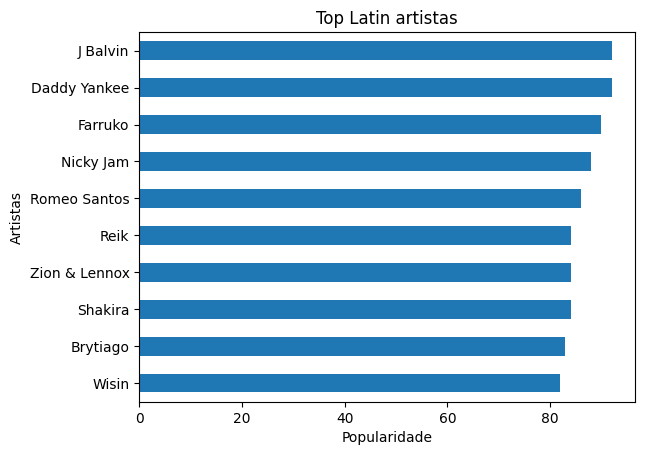

In [25]:
latin_ranking.tail(10).plot(kind='barh')
plt.title('Top Latin artistas')
plt.ylabel('Artistas')
plt.xlabel('Popularidade')
plt.show()

### 3.13 - Top 10 Artistas mais seguidos

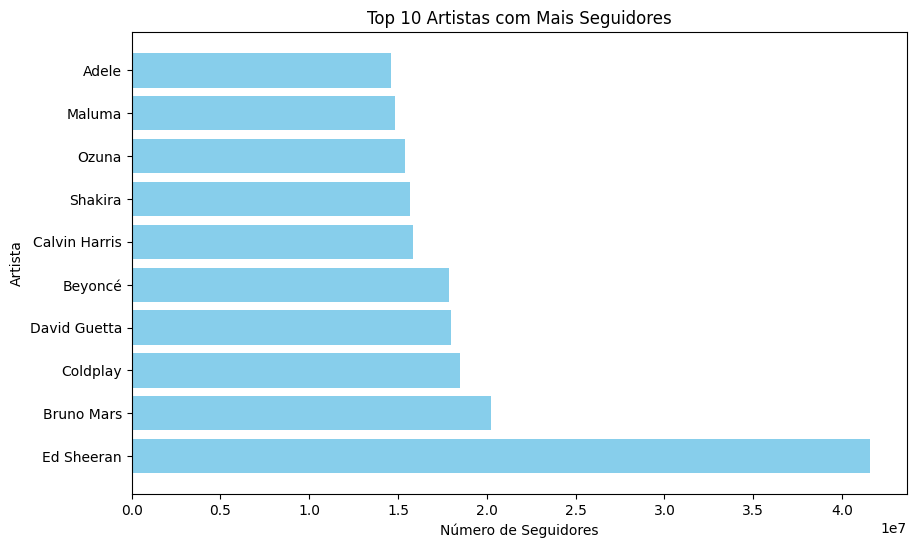

In [27]:
import matplotlib.pyplot as plt

# Selecionando os 10 artistas com mais seguidores
unique_artistas = db_final.drop_duplicates(subset='name_y')
top_10_artistas = unique_artistas.sort_values('followers', ascending=False).head(10)

# Criando o gráfico de barras horizontais
plt.figure(figsize=(10, 6))
plt.barh(top_10_artistas['name_y'], top_10_artistas['followers'], color='skyblue')

# Adicionando título e rótulos aos eixos
plt.title('Top 10 Artistas com Mais Seguidores')
plt.xlabel('Número de Seguidores')
plt.ylabel('Artista')

# Exibindo o gráfico
plt.show()


### 3.14 - Playlists mais populares

In [ ]:
album_popularity = db_final.groupby('playlist')['popularity'].mean().reset_index()
top_albuns = album_popularity.sort_values('popularity', ascending=False).head(10)
fig = px.bar(
    top_albuns,
    x='popularity',
    y='playlist',
    orientation='h',
    title='Top 10 PLaylists Mais Populares (Média de Popularidade das Músicas) ',
    labels={'popularity': 'Popularidade Média', 'playlist': 'Playlist'},)

fig.update_yaxes(categoryorder='total ascending')
fig.update_layout(template='plotly_white')

fig.show()

### 3.15 - Artistas ideais para vendas

Esta análise foi realizada com o objetivo de identificar quais artistas têm o maior potencial para vender CDs, considerando dois fatores cruciais: popularidade e número de seguidores. A premissa por trás dessa análise é que deve-se focar em artistas que não apenas sejam populares no momento, mas que também possuam uma base fiel de fãs.
As duas variáveis (popularidade e seguidores) foram normalizadas utilizando a técnica de MinMaxScaler para que ficassem na mesma escala de 0 a 1. Isso permite que ambas as métricas sejam comparadas de forma justa, sem que uma sobreponha a outra devido às suas escalas diferentes.
Para identificar os artistas com maior potencial de vendas, foi criada uma pontuação combinada (chamada final_score). Essa pontuação leva em consideração a média da popularidade e a média dos seguidores. Ou seja, a análise não apenas favorece artistas populares no momento, mas também dá peso aos artistas com bases de fãs grandes e fiéis.



In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
dance_pop_artistas[['pop_norm', 'followers_norm']] = scaler.fit_transform(
    dance_pop_artistas[['artist_popularity', 'followers']])

dance_pop_artistas['final_score'] = (dance_pop_artistas['pop_norm'] + dance_pop_artistas['followers_norm']) / 2

ranking_final = dance_pop_artistas.groupby('name_y')['final_score'].mean().reset_index()

ranking_final = ranking_final.sort_values(by='final_score', ascending=False)

fig = px.bar(
    ranking_final.head(10),
    x='name_y',
    y='final_score',
    title='Top 10 Artistas (Popularidade + Seguidores)',
    labels={'name_y': 'Artista', 'final_score': 'Pontuação Final'},)

fig.update_layout(template='plotly_white')

fig.show()

C:\Users\fguar\AppData\Local\Temp\ipykernel_23136\3616349920.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\fguar\AppData\Local\Temp\ipykernel_23136\3616349920.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

